# Introduction

Facial expression classification is a challenging task in computer vision, with various practical applications. In this tutorial, we will investigate the use of three deep learning models, EfficientNetB4, ResNet-50 and VGG16, to classify facial expression images into seven categories which are as follows:

  0. Angry 
  1. Disgust 
  2. Fear
  3. Happy
  4. Sad
  5. Surprise
  6. Neutral

The dataset used in this tutorial was obtained from Kaggle and contains 48x48 grayscale images of faces. The training set includes 28,709 images, and the test set has 7,178 images. All faces in the dataset are aligned and normalized, providing a consistent amount of space for each image, making it an optimal dataset for deep learning training. Additionally, we used data augmentation and normalization techniques to enhance the model's performance.

# Imports

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim

from torchvision import transforms, models 

import glob
import time

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

Set the device to be used during this tutorial

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: ', device)

Device:  cuda:0


# Constants

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = 0
NUM_EPOCHS = 100
PATIENCE = 10

# Prepare the Dataset

## Download and Split Data into Sets

The dataset being used is originally from https://www.kaggle.com/datasets/msambare/fer2013

We have stored it on Google Drive for convenience. Download and unzip:

In [ ]:
!gdown "1KEsD2-QDKQG_xRzNYfFIMU8a4chPoD4F&confirm=t"
!unzip -q fer2013.zip -d fer2013

Downloading...
From: https://drive.google.com/uc?id=1KEsD2-QDKQG_xRzNYfFIMU8a4chPoD4F&confirm=t
To: /content/fer2013.zip
100% 63.3M/63.3M [00:02<00:00, 21.7MB/s]


The dataset comes already split into development (train) and test sets. We will load the images and labels from these two set, and then take a look at the different classes.

In [ ]:
dev_dir = "/content/fer2013/train"
test_dir = "/content/fer2013/test"

dev_images = glob.glob(dev_dir + "/*/*.jpg")
dev_images = np.array(dev_images)
dev_labels = np.array([f.split("/")[-2] for f in dev_images])

test_images = glob.glob(test_dir + "/*/*.jpg")
test_images = np.array(test_images)
test_labels = np.array([f.split("/")[-2] for f in test_images])

In [ ]:
classes = np.unique(dev_labels).flatten()
num_classes = classes.size

print("There are", num_classes, "classes")
for i,j in enumerate(classes):
  print("Label", i, ":", j)

There are 7 classes
Label 0 : angry
Label 1 : disgust
Label 2 : fear
Label 3 : happy
Label 4 : neutral
Label 5 : sad
Label 6 : surprise


The model will require the labels to have numerical representation since it will not understand strings.

We will create label arrays for both sets of data using integers instead of the strings that they came with.

In [ ]:
# convert the string labels to integers
def labels_to_int(labels):
  classes = np.unique(dev_labels).flatten()
  labels_int = np.zeros(labels.size, dtype = np.int64)
  for i, j in enumerate(classes):
    labels_int[labels == j] = i
  return labels_int

test_labels_int = labels_to_int(test_labels)
dev_labels_int = labels_to_int(dev_labels)

We will split the development set into train set and validation set and show the final size of all three data sets. 

In [ ]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size= 0.2, random_state=10)
sss.get_n_splits(dev_images,dev_labels_int)
train_index, val_index = next(sss.split(dev_images,dev_labels_int))

train_images = dev_images[train_index]
train_labels_int = dev_labels_int[train_index]

val_images = dev_images[val_index]
val_labels_int = dev_labels_int[val_index] 

In [ ]:
train_count = len(train_images)
val_count = len(val_images)
test_count = len(test_images)

total = train_count + test_count + val_count
train_percent = train_count/total * 100
val_percent = val_count/total * 100
test_percent = test_count/total * 100

print("Number of images in the train set:", train_count)
print("Number of images in the validation set:", val_count)
print("Number of images in the test set:", test_count)

print("The split is {:.0f}% train set, {:.0f}% validation set, {:.0f}% test set".format(train_percent, val_percent, test_percent))

Number of images in the train set: 22967
Number of images in the validation set: 5742
Number of images in the test set: 7178
The split is 64% train set, 16% validation set, 20% test set


Lets visual the dataset. A random image is shown from each of the provided classes. 

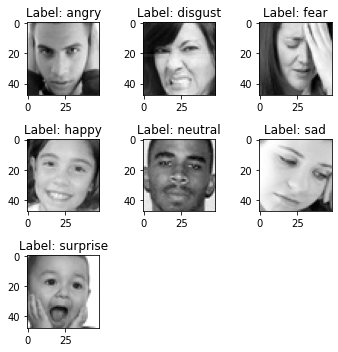

In [ ]:
def plot_original_images(images, labels, class_names):
    #     # plot up to num_images_per_class images for the current class
    plt.figure(figsize = (5,5), layout = 'tight')
    
    for i in range(len(class_names)):
        # get images for the current class
        class_index = np.random.choice(np.where(labels == class_names[i])[0], 1, replace=False)[0]
        plt.subplot(3,3,i+1)
        plt.imshow(plt.imread(images[class_index]), cmap='gray')
        plt.title("Label: %s" %(labels[class_index]))
    plt.show()
  

plot_original_images(dev_images, dev_labels, classes)

Let's check to make sure the labels are evenly distributed (stratified) across all three sets of data. It is important that the data is in equal proportions in each set so that the model can properly learn and predict from each class.

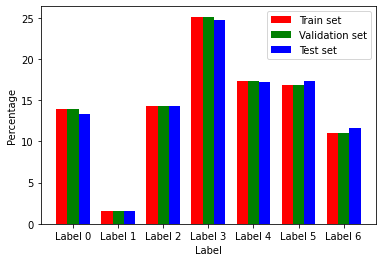

In [ ]:
def get_label_distribution(labels):
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    label_perc = label_counts / np.sum(label_counts) * 100

    # Format the label names and percentages as strings
    label_names = ['Label {}'.format(int(i)) for i in unique_labels]
    label_perc_str = ['{:.1f}%'.format(p) for p in label_perc]

    return label_names, label_perc

# Define the labels and corresponding percentages for each set
train_labels, train_perc = get_label_distribution(train_labels_int)
val_labels, val_perc = get_label_distribution(val_labels_int)
test_labels, test_perc = get_label_distribution(test_labels_int)

bar_width = 0.25
x_train = np.arange(len(train_labels))
x_val = [x + bar_width for x in x_train]
x_test = [x + bar_width for x in x_val]

plt.bar(x_train, train_perc, width=bar_width, color='r', label='Train set')
plt.bar(x_val, val_perc, width=bar_width, color='g', label='Validation set')
plt.bar(x_test, test_perc, width=bar_width, color='b', label='Test set')

# Set the x-axis labels and tick marks
plt.xlabel('Label')
plt.ylabel('Percentage')
plt.xticks([x + bar_width for x in range(len(train_labels))], train_labels)

plt.legend()
plt.show()

## Dataset Class Definition and Data Loaders
The Dataset class has been defined below:

In [ ]:
class FERDataset(Dataset):
    def __init__(self, data_dic, transform = None):
        self.file_paths = data_dic["X"]
        self.labels = data_dic["Y"]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self,idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]

        image = Image.open(file_path)

        if self.transform:
            image_transformed = self.transform(image)

        return image_transformed, label 

    def get_original_data(self):
        original_data = []
        for file_path, label in zip(self.file_paths, self.labels):
            image = Image.open(file_path)
            original_data.append((image, label))
        return original_data

Create the dictionaries to be used within the Dataset class. This will be done for all 3 data sets (train, val, test). These will be used when constructing our dataset classes. 

In [ ]:
train_set = { "X": train_images, "Y": train_labels_int }
val_set = { "X": val_images, "Y": val_labels_int }
test_set = { "X": test_images, "Y": test_labels_int }

Create the transforms to apply to the 
images. Here we can complete data augmentation to improve our data set and reduce overfitting. These will be used when constructing our dataset classes. 

In [ ]:
# mean and std were taken from a previous iteration of this notebook.
# it is not possible to save these into a variable as there is a circular dependency
mean = [0.4670, 0.4670, 0.4670]
std = [0.2440, 0.2440, 0.2440]

torchvision_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)

])

torchvision_transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

Now, create the PyTorch dataset classes for train, validation, and test.

In [ ]:
train_dataset = FERDataset(train_set, transform=torchvision_transform)
val_dataset = FERDataset(val_set, transform=torchvision_transform)
test_dataset = FERDataset(test_set, transform=torchvision_transform_test)

Create the PyTorch dataloaders

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Calculate the Mean and Standard Deviation for Normalization

Below are the statistics for the dataset. These values were taken from an earlier run and passed back into the transforms for normalization in the cells above.

This cell was not run again on the final pass, so the values seen in the output below are the values used for normalization.

In [ ]:
def get_dataset_stats(data_loader):
  mean = 0
  std = 0
  num_samples = 0
  for data in data_loader:
    data = data[0]
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    num_samples += batch_samples
  mean /= num_samples
  std /= num_samples
  return mean, std

In [ ]:
# train_stats = get_dataset_stats(train_loader)
# print("Train Data Set stats:", train_stats)

Visualize the data after the transformation and augmentation. The normalization transform is responsible for giving the faces the look that will keep you awake at night.



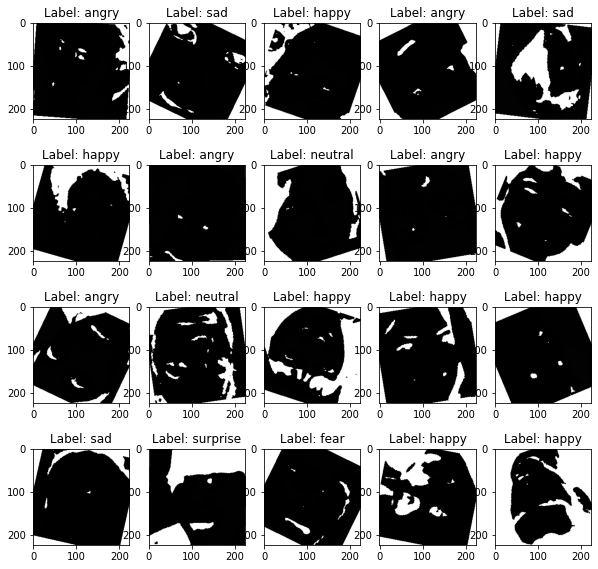

In [ ]:
train_iterator = iter(train_loader)
images, labels = next(train_iterator)
batch_size = len(labels)

plt.figure(figsize = (10,10))
for (i,j) in enumerate(range(20)):
    plt.subplot(4,5,i+1)
    plt.imshow(images.numpy()[j].transpose(1,2,0).astype('uint8'))
    plt.title("Label: %s" %(classes[labels[j]]))
plt.show()

# Define The Deep Learning Model

The class below represents the neural network model:


In [ ]:
class FERModel(nn.Module):
  def __init__(self, num_classes, input_shape, model_name, transfer):
    super().__init__()

    self.transfer = transfer
    self.num_classes = num_classes
    self.input_shape = input_shape

    # These models were chosen based on the accuracy/runtime tradeoffs summarized by PyTorch and Keras:
    # https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights
    # https://keras.io/api/applications/
    available_models = {
      'efficientnet_b4': models.efficientnet_b4,
      'resnet50': models.resnet50,
      'vgg16': models.vgg16,
    }

    if model_name not in available_models:
      raise ValueError(f"Invalid model name: {model_name}")


    # only load weights if we are doing transfer learning 
    if not self.transfer:
      pretrained_weights = None
    else:
      pretrained_weights='DEFAULT'
    
    self.feature_extractor = available_models[model_name](weights=pretrained_weights)

    if self.transfer:
      self.feature_extractor.eval()
      for param in self.feature_extractor.parameters():
        param.requires_grad = False
    
    n_features = self._get_conv_output(self.input_shape)
    self.classifier = nn.Linear(n_features, num_classes)

  def _get_conv_output(self, shape):
    batch_size = 1
    tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))
    output_feat = self.feature_extractor(tmp_input)
    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size
    
  def forward(self, x):
    x = self.feature_extractor(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x     

# Train The Model

## Define the Training Function

The function below will train and save the model at the end of each epoch if the validation loss improves. `model_name` and `transfer_learning` are two parameters that must be provided that will dictate the model we use for training.

The results of the loss and accuracy at the end of each epoch are printed and graphed to illustrate how the training process converges.

In [ ]:
# Define parameters for model
input_shape = (3, 224, 224)

def train_model(model_name, transfer_learning):
    PATH = f"/content/{model_name}_TL={transfer_learning}_model"
    
    # Define parameters for model
    nn_model = FERModel(num_classes, input_shape, model_name, transfer_learning)
    nn_model.to(device)

    # Define optimizer and scheduler
    optimizer = optim.AdamW(nn_model.parameters(), lr = 0.0001)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    # Define loss function and initialize variables for tracking losses and accuracies
    criterion = nn.CrossEntropyLoss()
    best_loss = 1e+20
    patience_counter = 0
    start_time = time.time()
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    # Train the model
    print(f'Training Model: {model_name} with Transfer Learning={transfer_learning}')
    for epoch in range(NUM_EPOCHS):
        print(f'Epoch {epoch}/{NUM_EPOCHS - 1}')
        print('-' * 20)

        # Training Phase of the Epoch
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            outputs = nn_model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = 100 * train_correct / train_total
        train_losses.append(train_loss / i)
        train_accs.append(train_accuracy)
        print(f"train loss: {train_loss / i:.3f}, train acc: {train_accuracy:.3f}%", end=", ")

        # Validation phase of the epoch. Here we are not training, just
        # evaluating, therefore gradients for the outputs do not need to be calculated.
        with torch.no_grad():
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            for i, data in enumerate(val_loader, 0):
                images, labels = data[0].to(device), data[1].to(device)
                outputs = nn_model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

            val_accuracy = 100 * val_correct / val_total
            val_losses.append(val_loss / i)
            val_accs.append(val_accuracy)
            print(f"val loss: {val_loss / i:.3f}, val acc: {val_accuracy:.3f}%")

            if val_loss < best_loss:
                print("Saving model")
                torch.save(nn_model.state_dict(), PATH)
                best_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= PATIENCE:
                    print(f"Early stopping at epoch {epoch} with val loss: {val_loss:.3f}")
                    break

            scheduler.step()
        print()

    time_elapsed = time.time() - start_time
    print("Training Complete")
    print(f'Training Time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # Plot the training and validation loss and accuracy
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the training and validation loss
    axs[0].plot(range(len(train_losses)), train_losses, label='Train Loss')
    axs[0].plot(range(len(val_losses)), val_losses, label='Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_title('Model: {} | Transfer Learning: {}'.format(model_name, transfer_learning))

    # Plot the training and validation accuracy
    axs[1].plot(range(len(train_accs)), train_accs, label='Train Accuracy')
    axs[1].plot(range(len(val_accs)), val_accs, label='Validation Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].legend()
    axs[1].set_title('Model: {} | Transfer Learning: {}'.format(model_name, transfer_learning))

    plt.show()

    return best_loss

## Train Different Models on the Data

We will use `efficientnet_b4`, `vgg16` and `resnet50` models with both transfer learning on and off to see how each performs. The transfer learning uses the default (best performing) weights from PyTorch database that were obtained by training on Imagenet, and only the dense layers are re-trained. With transfer learning off, the initial weights are randomized and all layers are re-trained. We will then use the best model of the six to test the model on new data.

Training Model: efficientnet_b4 with Transfer Learning=True
Epoch 0/99
--------------------
train loss: 1.680, train acc: 33.844%, val loss: 1.590, val acc: 38.662%
Saving model

Epoch 1/99
--------------------
train loss: 1.557, train acc: 40.632%, val loss: 1.551, val acc: 41.048%
Saving model

Epoch 2/99
--------------------
train loss: 1.516, train acc: 42.217%, val loss: 1.513, val acc: 42.355%
Saving model

Epoch 3/99
--------------------
train loss: 1.494, train acc: 43.092%, val loss: 1.497, val acc: 43.225%
Saving model

Epoch 4/99
--------------------
train loss: 1.481, train acc: 43.619%, val loss: 1.486, val acc: 44.009%
Saving model

Epoch 5/99
--------------------
train loss: 1.463, train acc: 44.533%, val loss: 1.482, val acc: 44.758%
Saving model

Epoch 6/99
--------------------
train loss: 1.452, train acc: 44.803%, val loss: 1.475, val acc: 43.835%
Saving model

Epoch 7/99
--------------------
train loss: 1.447, train acc: 45.230%, val loss: 1.466, val acc: 44.706%
Sa

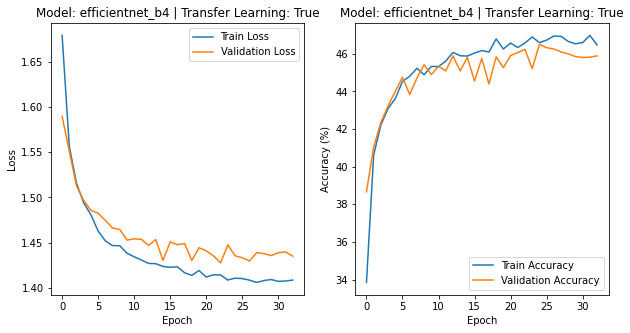

Training Model: efficientnet_b4 with Transfer Learning=False
Epoch 0/99
--------------------
train loss: 1.845, train acc: 24.248%, val loss: 1.844, val acc: 24.852%
Saving model

Epoch 1/99
--------------------
train loss: 1.802, train acc: 25.293%, val loss: 1.806, val acc: 25.479%
Saving model

Epoch 2/99
--------------------
train loss: 1.789, train acc: 25.641%, val loss: 1.787, val acc: 27.081%
Saving model

Epoch 3/99
--------------------
train loss: 1.773, train acc: 26.377%, val loss: 1.768, val acc: 27.708%
Saving model

Epoch 4/99
--------------------
train loss: 1.732, train acc: 29.821%, val loss: 1.708, val acc: 31.714%
Saving model

Epoch 5/99
--------------------
train loss: 1.648, train acc: 34.419%, val loss: 1.619, val acc: 35.684%
Saving model

Epoch 6/99
--------------------
train loss: 1.562, train acc: 38.390%, val loss: 1.540, val acc: 39.777%
Saving model

Epoch 7/99
--------------------
train loss: 1.483, train acc: 42.191%, val loss: 1.470, val acc: 43.121%
S

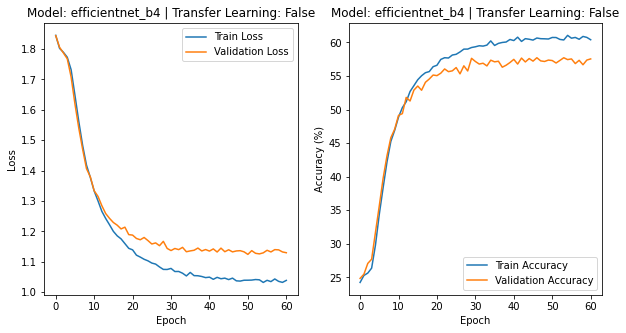

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Training Model: vgg16 with Transfer Learning=True
Epoch 0/99
--------------------
train loss: 1.763, train acc: 29.168%, val loss: 1.714, val acc: 31.661%
Saving model

Epoch 1/99
--------------------
train loss: 1.676, train acc: 32.664%, val loss: 1.678, val acc: 34.030%
Saving model

Epoch 2/99
--------------------
train loss: 1.661, train acc: 34.053%, val loss: 1.666, val acc: 35.301%
Saving model

Epoch 3/99
--------------------
train loss: 1.649, train acc: 34.571%, val loss: 1.656, val acc: 35.145%
Saving model

Epoch 4/99
--------------------
train loss: 1.639, train acc: 35.298%, val loss: 1.649, val acc: 35.371%
Saving model

Epoch 5/99
--------------------
train loss: 1.636, train acc: 35.203%, val loss: 1.653, val acc: 35.336%

Epoch 6/99
--------------------
train loss: 1.633, train acc: 35.699%, val loss: 1.647, val acc: 36.451%
Saving model

Epoch 7/99
--------------------
train loss: 1.630, train acc: 35.516%, val loss: 1.652, val acc: 35.650%

Epoch 8/99
-------------

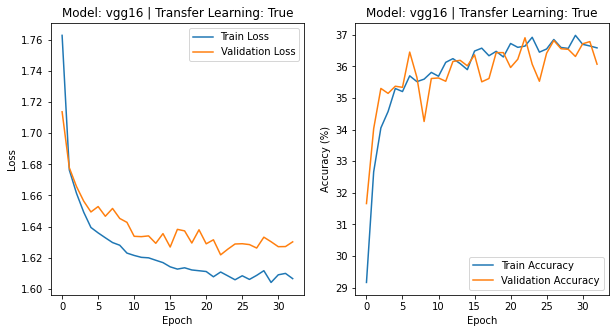

Training Model: vgg16 with Transfer Learning=False
Epoch 0/99
--------------------
train loss: 1.812, train acc: 24.840%, val loss: 1.800, val acc: 25.218%
Saving model

Epoch 1/99
--------------------
train loss: 1.762, train acc: 27.082%, val loss: 1.701, val acc: 29.920%
Saving model

Epoch 2/99
--------------------
train loss: 1.675, train acc: 31.989%, val loss: 1.620, val acc: 35.493%
Saving model

Epoch 3/99
--------------------
train loss: 1.519, train acc: 40.014%, val loss: 1.438, val acc: 44.549%
Saving model

Epoch 4/99
--------------------
train loss: 1.374, train acc: 46.841%, val loss: 1.343, val acc: 49.390%
Saving model

Epoch 5/99
--------------------
train loss: 1.289, train acc: 50.586%, val loss: 1.258, val acc: 51.602%
Saving model

Epoch 6/99
--------------------
train loss: 1.229, train acc: 53.072%, val loss: 1.220, val acc: 53.274%
Saving model

Epoch 7/99
--------------------
train loss: 1.176, train acc: 55.014%, val loss: 1.189, val acc: 54.911%
Saving mode

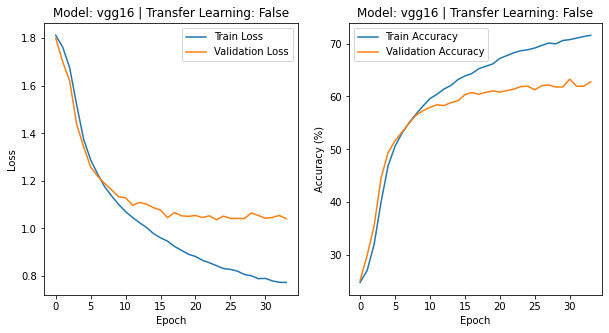

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Training Model: resnet50 with Transfer Learning=True
Epoch 0/99
--------------------
train loss: 1.712, train acc: 30.840%, val loss: 1.658, val acc: 34.814%
Saving model

Epoch 1/99
--------------------
train loss: 1.617, train acc: 36.596%, val loss: 1.615, val acc: 37.426%
Saving model

Epoch 2/99
--------------------
train loss: 1.581, train acc: 38.938%, val loss: 1.584, val acc: 39.324%
Saving model

Epoch 3/99
--------------------
train loss: 1.565, train acc: 39.478%, val loss: 1.563, val acc: 40.839%
Saving model

Epoch 4/99
--------------------
train loss: 1.546, train acc: 40.475%, val loss: 1.566, val acc: 40.300%

Epoch 5/99
--------------------
train loss: 1.539, train acc: 40.741%, val loss: 1.552, val acc: 41.048%
Saving model

Epoch 6/99
--------------------
train loss: 1.528, train acc: 41.037%, val loss: 1.543, val acc: 41.135%
Saving model

Epoch 7/99
--------------------
train loss: 1.521, train acc: 41.542%, val loss: 1.532, val acc: 42.476%
Saving model

Epoch 8/

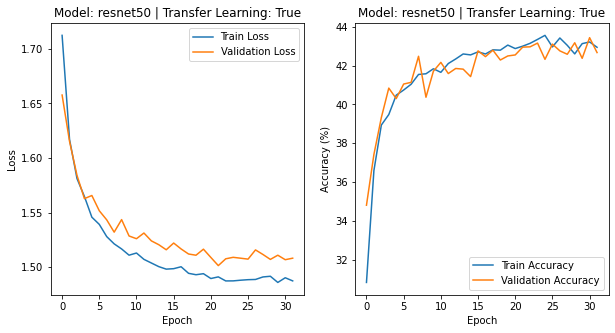

Training Model: resnet50 with Transfer Learning=False
Epoch 0/99
--------------------
train loss: 1.835, train acc: 23.778%, val loss: 1.812, val acc: 24.417%
Saving model

Epoch 1/99
--------------------
train loss: 1.783, train acc: 25.963%, val loss: 1.778, val acc: 27.569%
Saving model

Epoch 2/99
--------------------
train loss: 1.721, train acc: 29.386%, val loss: 1.711, val acc: 31.069%
Saving model

Epoch 3/99
--------------------
train loss: 1.571, train acc: 38.116%, val loss: 1.567, val acc: 39.951%
Saving model

Epoch 4/99
--------------------
train loss: 1.458, train acc: 43.253%, val loss: 1.430, val acc: 45.385%
Saving model

Epoch 5/99
--------------------
train loss: 1.383, train acc: 46.510%, val loss: 1.365, val acc: 47.562%
Saving model

Epoch 6/99
--------------------
train loss: 1.318, train acc: 49.615%, val loss: 1.294, val acc: 50.279%
Saving model

Epoch 7/99
--------------------
train loss: 1.267, train acc: 51.657%, val loss: 1.265, val acc: 51.759%
Saving m

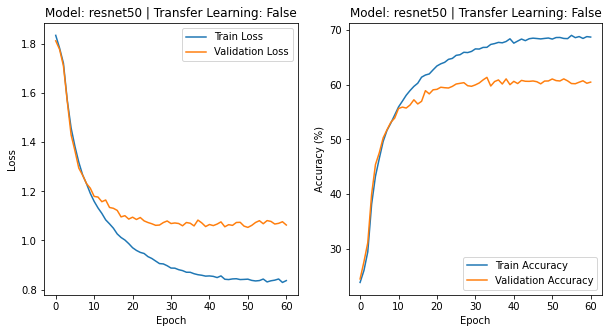

In [ ]:
model_types = ['efficientnet_b4', 'vgg16', 'resnet50']
transfer_learning = [True, False]
results = {}

for model in model_types:
  for tl in transfer_learning:
    result = train_model(model, tl)
    key = (model, tl)
    results[key] = result

As the graphs above show, the training accuracy continued to increase over time, while the validation accuracy hit a plateau. This is a sign that the model was beginning to overfit. A patience of 10 epochs was set so that if the validation loss didn't improve, then the training process would stop. The best model was saved and will be used on the test set below.

# Test the Model on New Data
Find and load the best model from the four options above based on the best validation loss.

In [ ]:
best_loss = 1e+20
best_model = None
for key in results:
  val_loss = results[key]
  if val_loss < best_loss:
    best_loss = val_loss
    best_model = key

model_name, transfer_learning = best_model
print(f"The Best Model was: {model_name} with Transfer Learning={transfer_learning}")
PATH = f"/content/{model_name}_TL={transfer_learning}_model"
nn_model_best = FERModel(num_classes, input_shape, model_name, transfer_learning)
nn_model_best.load_state_dict(torch.load(PATH))
nn_model_best.to(device)

# Save the best model's weights for future use
PATH = "/content/best_model_weights"
torch.save(nn_model_best.state_dict(), PATH)

The Best Model was: vgg16 with Transfer Learning=False


Use the test_loader to load the images we saved in the test set. We will now test the best model on this new data to determine accuracy on unseen data.

In [ ]:
# Get the original data before we applied any transformations
# We will use this to display some of the misclassified images in a more human-understandable format
test_data_orig = test_dataset.get_original_data()

In [ ]:
correct = 0
total = 0
all_predicted_labels = []
all_true_labels = []
misclassified_images = []

with torch.no_grad():

    for batch_idx, data in enumerate(test_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = nn_model_best(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predicted_labels.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())
        

        # Store the misclassified original images along with their true and predicted labels
        idx = batch_idx * test_loader.batch_size
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                misclassified_images.append((test_data_orig[idx+i][0], labels[i], predicted[i]))

# Analyze the Final Results

In [ ]:
overall_accuracy = 100 * correct / total
print('Overall Accuracy of the model: {:.2f} %'.format(overall_accuracy))

Overall Accuracy of the model: 62.05 %


In [ ]:
classification_report = classification_report(all_true_labels, all_predicted_labels, target_names=classes)
print('Accuracy per Class:\n', classification_report)

Accuracy per Class:
               precision    recall  f1-score   support

       angry       0.55      0.53      0.54       958
     disgust       0.52      0.22      0.31       111
        fear       0.44      0.37      0.40      1024
       happy       0.82      0.88      0.85      1774
     neutral       0.58      0.57      0.58      1233
         sad       0.47      0.56      0.51      1247
    surprise       0.77      0.69      0.73       831

    accuracy                           0.62      7178
   macro avg       0.59      0.55      0.56      7178
weighted avg       0.62      0.62      0.62      7178



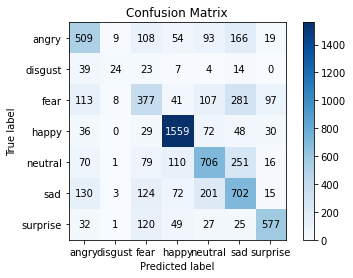

In [ ]:
cm = confusion_matrix(all_true_labels, all_predicted_labels)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

Plot 5 misclassified images from each class so that we can get an intuitive sense of why the model might be missing classifications.

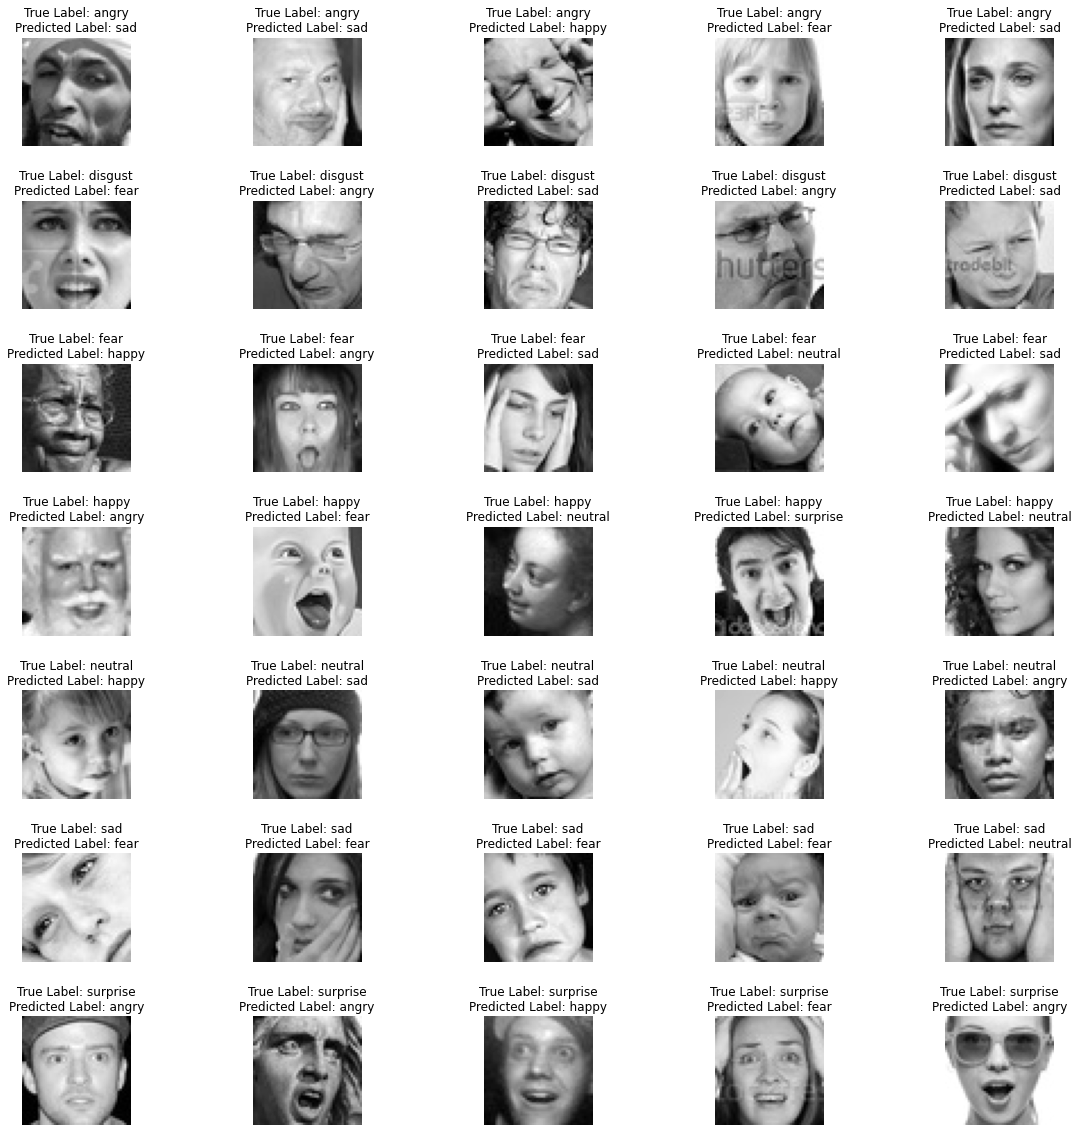

In [ ]:
def plot_images(images, class_names):
    num_classes = len(class_names)
    num_images_per_class = 5

    # create 2D array of Axes objects
    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.5)
    
    # plot images for each class
    for i in range(num_classes):
        # get images for the current class
        class_images = [img for img in images if img[1] == i]
        
        # plot up to num_images_per_class images for the current class
        for j in range(min(num_images_per_class, len(class_images))):
            ax = axes[i, j]  # get the corresponding Axes object
            img, true_label, pred_label = class_images[j]
            ax.imshow(np.array(img), cmap='gray')
            ax.set_title(f'True Label: {class_names[true_label]}\nPredicted Label: {class_names[pred_label]}')
            ax.axis('off')
    
    plt.show()


plot_images(misclassified_images, classes)